# Preliminaries
Data preprocessing in order to feed our CNN. The following considerations are taking into account:

* To read the data, Uproot is faster than Pyroot. However, we do not know if the software can be installed properly at CUDA and CIEMAT computers. 
* Software to reduce the size of the images, but keeping the signal and important caracteristics.
* A method to store this data efficiently. Probably png or csv files.

# READ DATA

In [136]:
########## dependencies ###########
import uproot  ### https://github.com/scikit-hep/uproot#exploring-a-ttree
import numpy as np
import matplotlib.pyplot as plt

In [137]:
file = uproot.open("/scratch/deandres/MC/Electrons/reco/Electron_reco_0.root")
print("the data contained in the file has the following keys: ",file[file.keys()[0]].keys())
print("We can access the data using")

the data contained in the file has the following keys:  [b'anatree;72', b'anatree;71']
We can access the data using


In [138]:
# we can display all the information stored in the TTree
tree=file["analysistree"]["anatree"] 
tree.show()

Run                        (no streamer)              asdtype('>i4')
Subrun                     (no streamer)              asdtype('>i4')
EventNumberInRun           (no streamer)              asdtype('>i4')
EventTimeSeconds           (no streamer)              asdtype('>i4')
EventTimeNanoseconds       (no streamer)              asdtype('>i4')
IsData                     (no streamer)              asdtype('int8')
RecoWaveforms_NumberOfChannels
                           (no streamer)              asdtype('>i4')
RecoWaveform_Channel       (no streamer)              asjagged(asdtype('>i4'))
RecoWaveform_NTicks        (no streamer)              asjagged(asdtype('>i4'))
RecoWaveform_NumberOfTicksInAllChannels
                           (no streamer)              asdtype('>i4')
RecoWaveform_Tick          (no streamer)              asjagged(asdtype('>i4'))
RecoWaveform_ADC           (no streamer)              asjagged(asdtype('>f4'))
NumberOfHits               (no streamer)              asdtyp

In [139]:
print(tree.array(b'RecoWaveform_Channel')[98].shape) ## 1280 channels
print(tree.array( b'RecoWaveform_NTicks')[98]) ## each channel 1667 ticks , the explanatory pdf is wrong!

(1280,)
[1667 1667 1667 ... 1667 1667 1667]


* It seems that theere are 1280 channels and 1667 ticks. 
* first view from 0 to 319 and second the rest (320-1280). 

In [140]:
#ADC = tree.array( b'RecoWaveform_ADC')
#NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
#Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
#NTracks=tree.array(b'NumberOfTracks')
#w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
#print(w,h)

# Unable to load the data !!!
If you run the code from above, you may notice that there is not enough memory to access all the data. Therefore, we may need to manage the memory usage. In order to do that, I found 2 ways: 

1. Lazy arrays: This method allows us to read the data on demand
2. Caching arrays: This method allows us to control the memory usage, in a Python dict.
3. Use PyROOT

What we did above is
```
ADC = tree.array( b'RecoWaveform_ADC')
```
And this array methods reas the file of cache immediately and returs in-memory array. This is why it is not working.

In [179]:
#1. Try Lazy arrays: 
##### from #https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray #####
#data = tree.lazyarrays(entrysteps=1)  
#ADC=data["RecoWaveform_ADC"] # This should gives us the number of events
# This contains a virtual array, which is read when any element of it is accessed, for instance0:33 / 4:16
#print(ADC[0])

# It appears that the code from above is not working
ADC=tree['RecoWaveform_ADC']
print(ADC) # it seem this is an object called <TBranch b'RecoWaveform_ADC' at 0x7f226a47c828>

###### How to access this data #######
basketcache={} 
lazy=ADC.lazyarray(basketcache=basketcache) # this should work 
print(basketcache) # as you can see the objects are being saved in this basket  
lazy[0]
# we are really using the same memmory twice, this means that 

<TBranch b'RecoWaveform_ADC' at 0x7f226bcc8ac8>
{}


array([-1.,  1.,  0., ...,  1., -1.,  0.], dtype=float32)

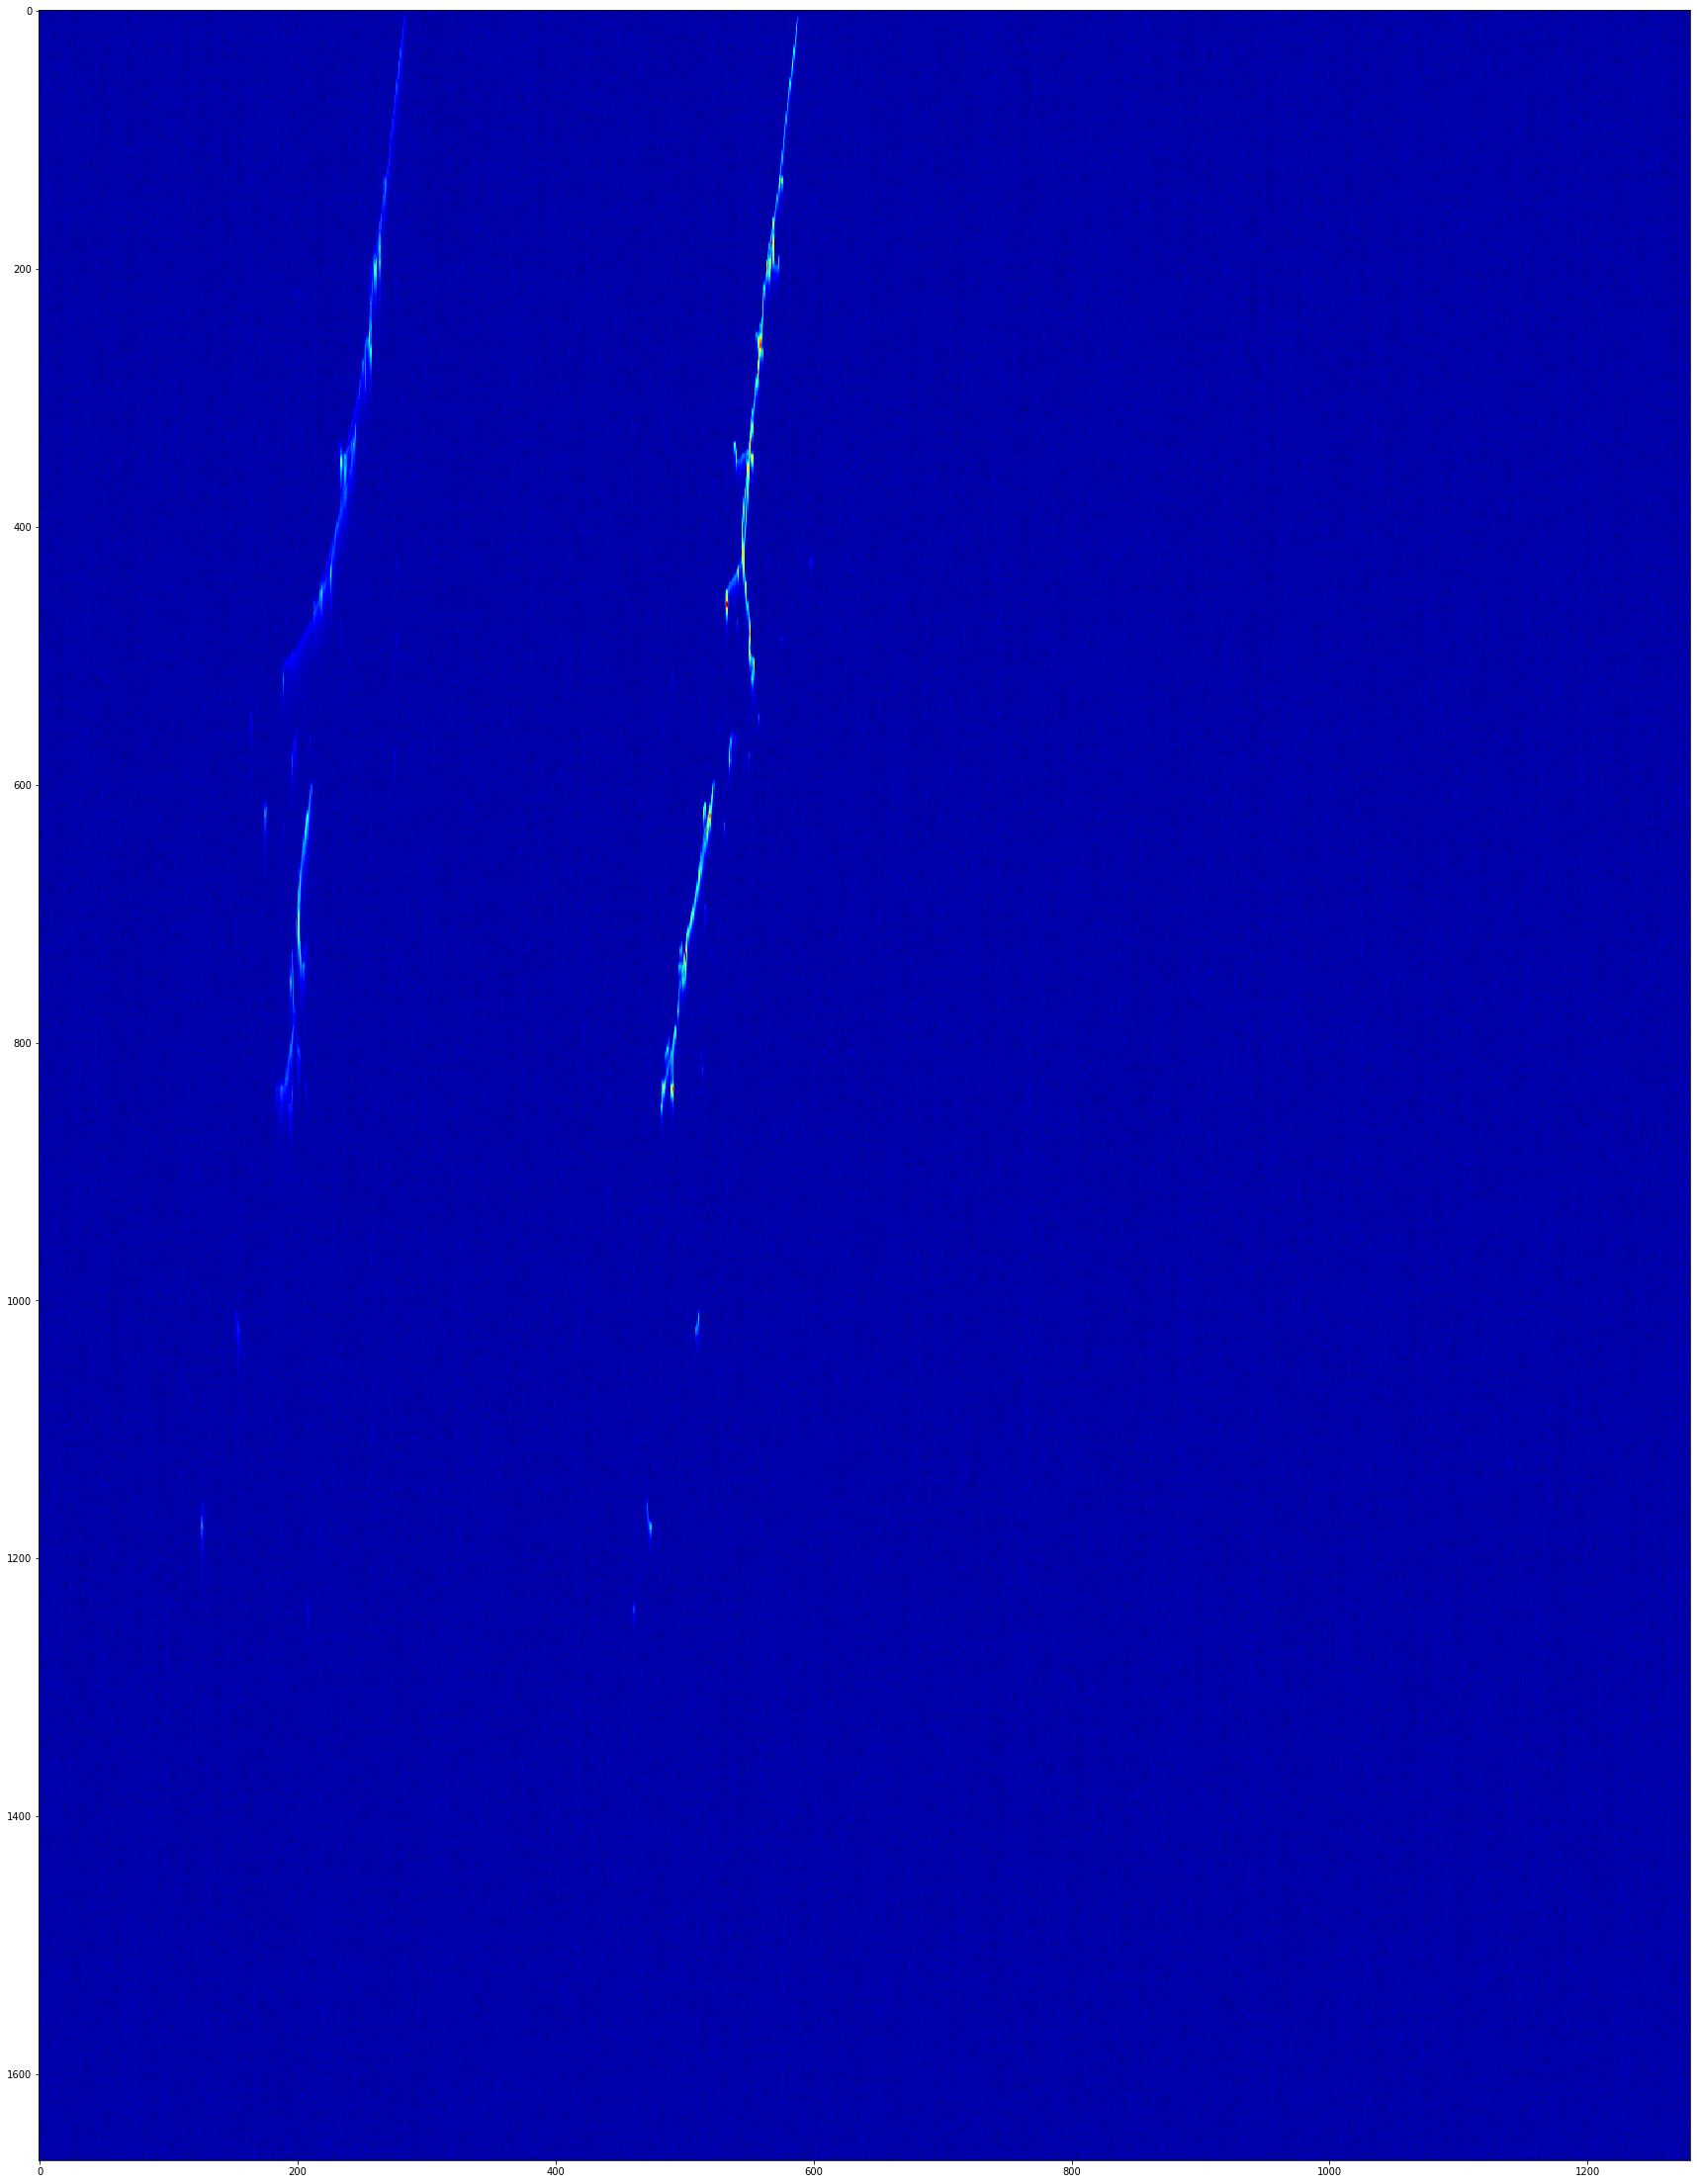

In [185]:
w=1280
h=1667
basketcache={}
im=lazy[200].reshape((w,h))
v1=im
fig = plt.figure()
plt.imshow(v1.T,cmap = 'jet', interpolation='none')
fig.set_size_inches(30, 40) ##grey scale
plt.savefig('big.png')

# it works!!!!!!

In [186]:
def maxpool(im, h, w):
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    
    
    ########The algorithm#########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            pool=im[i*h_step:h_step*(i+1),j*w_step:(j+1)*w_step]
            reduced_im[i,j]=np.max(pool)
            
            
    return reduced_im

In [187]:
def maxpoolmod(im, h, w):
    # observacions, modifications to account for issues regarding h_step ~ 1
    #####the imputs#####
    # im.shape must be a matrix of(width, height)
    # w and h are the output weight and height respectively .
    
#### preliminaries###
    h_step=im.shape[0]//h
    w_step=im.shape[1]//w
    #print("we have lost", (im.shape[1]%w)*(im.shape[0]%h), "pixels along the way")
    
    reduced_im=np.zeros((h,w)) ##the new reduced matrix is initialized with zeros
    extra_pixels=im.shape[0]-(im.shape[0]//h)*h
    #print(extra_pixels)
    loss_h = (im.shape[0]//h *h)/im.shape[0] ##the percented of the image that we will lose
    #print('we are loosing without processing', 1-loss_h ,'pixels')
    count=0
    ##########The algorithm##########
    for i in range(0,h): #loop over h
        for j in range(0,w): #loop over w
            r=np.random.uniform()
            #print(count,r,':',i,j)
            if r>extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
            if r<extra_pixels/h/w and count<extra_pixels:
                pool=im[i*h_step+count:h_step*(i+1)+count,(j)*w_step:(j+1)*w_step]
                reduced_im[i,j]=np.max(pool)
                count=count+1     
    return reduced_im ,count

In [9]:
h=80
v1.shape[0]-v1.shape[0]//h*h
(57+36)*3

279

79
we are loosing without processing 0.2831541218637993 pixels
79


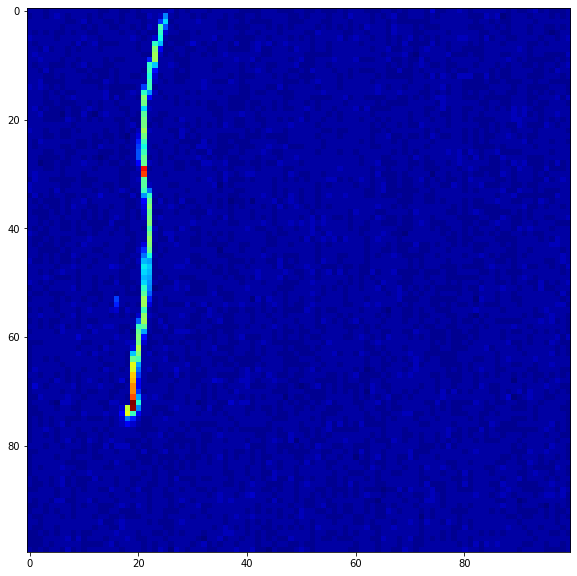

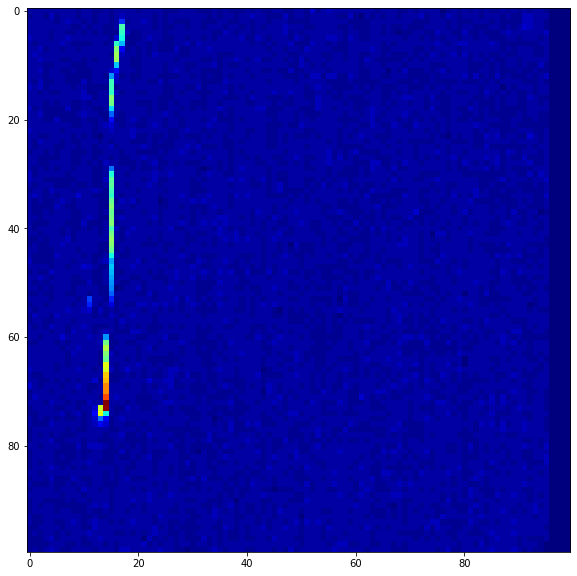

In [10]:
v1red=maxpool(v1,100,100)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

v1redmu, count=maxpoolmod(v1,100,100)
print(count)
fig = plt.figure(frameon = False)
plt.imshow(v1redmu.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

# Observaciones:
* the algorithm only works approximately if h and w are <<< im.shape . Otherwise, the algorithm will cut the image. 

* In order to account for this issue, what can be done is 

    1. reduce only the big axis, the one with
    2. modify the algorithm 

# Considerations: file size
In order to save memory, our data set must me made of these images. It can be stored in a cv file, or in a root tree. We will see how efficient is the root tree. Options: 

* use csv files with delimiter ',' : 200x200 img is ~900K
* use numpy.save : 200x200 img is ~300K
* use ROOT trees: 200x200 img is ~33K
* use png images: The data is not properly conserved, we do not have the numerical values but rather a png image that approximate this values. 

As far as disc memory is concerned, probably the best option to tackle this problem is using ROOT trees.

In [11]:
np.save('savenp',v1red) ### 
np.savetxt("foo.csv", v1red, delimiter=",")

In [12]:
from ROOT import TFile, TTree
import numpy as np

f = TFile('example.root', 'recreate')
t = TTree('mytree', 'example tree')

t.Branch('myarray', v1red, 'myarray[100][100]/D')
print(v1red.flatten().shape)

t.Fill()

f.Write()
f.Close()

Welcome to JupyROOT 6.18/00
(10000,)


In [106]:
import ROOT
import numpy as np

tfile = ROOT.TFile("example.root")
ttree = tfile.mytree

nentries = 1
for i in range(nentries):
    ttree.GetEntry(i)
    print(ttree.myarray)


Welcome to JupyROOT 6.18/00


AttributeError: TFile object has no attribute 'mytree'

In [14]:
v1red.flatten()[0]

2.0

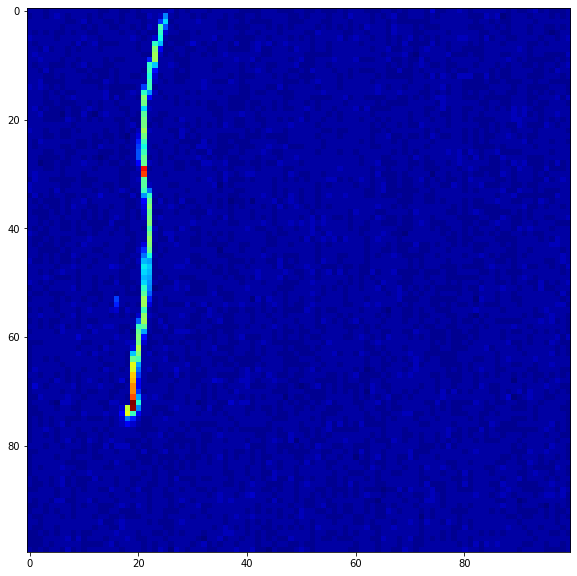

In [15]:
fig = plt.figure(frameon = False)
plt.imshow(v1red.flatten().reshape(100,100).T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

In [16]:
file=uproot.open("example.root")
tree=file[b'mytree;1']

In [17]:
im=tree.array( b'myarray')[0]

In [18]:
print(im.shape)
print(v1red.shape)

(100, 100)
(100, 100)


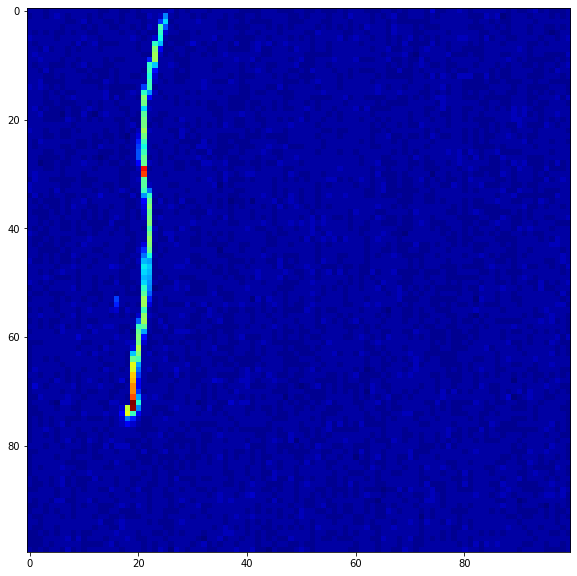

In [19]:
fig = plt.figure(frameon = False)
plt.imshow(im.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(10, 10) ##grey scale
plt.savefig('small.png')

This reduction algorithim must be uploaded into lxplus and then download the reduced data. Consequently, 1000 $e^{-}$ and 1000 $\mu^{-}$ waveforms must be around 60MB and 1 million waveforms 30 GB. I believe this 30 GB is a very reasonable number. 

We have to see if the image reduction algorithm also works for electrons. 

In [20]:
file = uproot.open("/Users/dan/CIEMAT/ROOT/ROOT_try/electrons/0-RecoFull-Parser.root")
tree=file["analysistree"]["anatree"] 

In [21]:
ADC = tree.array( b'RecoWaveform_ADC')
NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
NTracks=tree.array(b'NumberOfTracks')
w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
print(w,h)

1280 1667


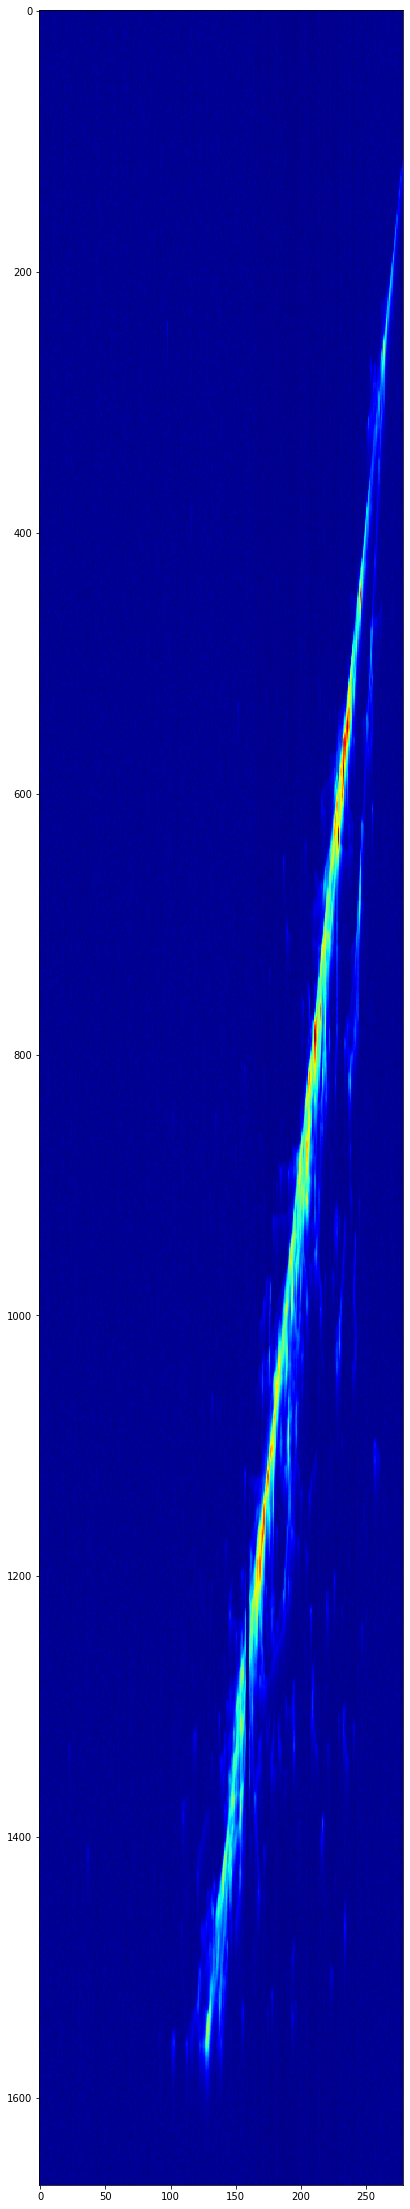

In [22]:
im=ADC[61].reshape((w,h))
v1=im[0:279,:]
fig = plt.figure(frameon = False)
plt.imshow(v1.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(30, 40) ##grey scale
plt.savefig('big.png')

In [31]:
v1red=maxpool(v1,100,100)
fig = plt.figure(frameon = False)
plt.imshow(v1red.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

v1rede, count=maxpoolmod(v1,100,100)
print(count)
fig = plt.figure(frameon = False)
plt.imshow(v1rede.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

NameError: name 'maxpool' is not defined

# Conclusions

Now our data is ready to feed our Deep Neural networks.

Conviene reducir a 100x100 pixeles

* bloque convolutivo
 1. kernel(5...7...9)
 2. bajar después+pooling (2x2)
* salida
 1. confusion matrix
 2. evolucion del fitness en funcion de la epoca

# Save images using uproot: not good yet

In [4]:
f=uproot.recreate("example.root")
f["tree"] = uproot.newtree({"branch": "int32"})
f["tree"].extend({"branch": v1rede.flatten()})

NameError: name 'v1rede' is not defined

In [19]:
f["tree"]

In [5]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

file1= uproot.open("example.root")
tree1=file1["tree"]
tree1.keys()

KeyError: not found: b'tree'
 in file: example.root

In [12]:
imagen=tree1.array(b'branch')
imagen=imagen.reshape(100,100)

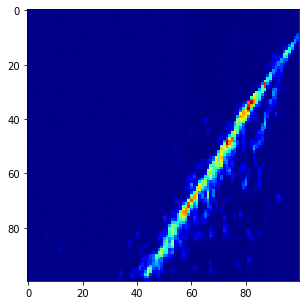

In [13]:
fig = plt.figure(frameon = False)
plt.imshow(imagen.T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

The point about uproot is that it cannot save the images as different events.The images must be stored and then reshaped. 

In [107]:
np.save("example",imagen) ## esier but double the space in Disk, might not be useful. For a simple example
#it can be used.

# Saving images 
* The reasonably efficient way

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from funciones import maxpool
from ROOT import TFile, TTree

Welcome to JupyROOT 6.18/00


In [2]:
def reducir(number_of_files=int(10)): #izquierda sin defoult derecha con.
    #### imput is the number of files to consider

    for i in range(0,number_of_files):

        file = uproot.open("{}-RecoFull-Parser.root".format(i))
        tree=file["analysistree"]["anatree"] 
        ADC = tree.array( b'RecoWaveform_ADC')
        NChannel=tree.array(b'RecoWaveforms_NumberOfChannels')
        Nticks=tree.array(b'RecoWaveform_NumberOfTicksInAllChannels')
        NTracks=tree.array(b'NumberOfTracks')
        w , h = int(NChannel[0]) , int(Nticks[0]/NChannel[0])
        #print(w,h)

        ###here a loop over files
        newsize=279
        v=np.zeros((newsize,newsize,100*number_of_files))
        vred=v
        for i in range(0,100*number_of_files):
            todo=ADC[i].reshape((w,h))
            v1=todo[0:279,:]
            v[:,:,i] = maxpool(v1,newsize,newsize)
    #### output is the rediced images as a numpy array
    return v

In [3]:
def guardar(v,filename):
    ##########description#########
    # this function stores the np vector 'v' into a 'root file'. Due to memory reasons, the other options are not
    # as good as root files.
    
    ###FUNCTION####
    ######dependences#####
    #from ROOT import TFile, TTree
    #import numpy as np
    a=v.flatten()
    f = TFile(filename, 'recreate')
    t = TTree('mytree', 'tree')
    
    
    t.Branch('im', a, 'myarray[{}]/D'.format(int(a.shape[0])))
    
    
    
    t.Fill()
    f.Write()
    f.Close()
    ##### output is None, this function will save the reduced images as a root file, it is probably not 
    ##### convinient to use the array. 
    return None

In [8]:
def abrir(file,dim):
    ######description########
    #this function opens our root file, and gives us a numpy vector of the proper dimensions.
    
    file = uproot.open(file)
    tree=file[b'mytree;1']
    im=tree.array(b'im')
    im=im.reshape(dim)
    return im

## Test the functions
* observations, reducir is a pretty slow function, it would be nice to consider a vectorized form of the function
* guardar and abrir are pretty fast

In [12]:
v = reducir(1)

In [15]:
guardar(v,"try.root")

In [16]:
im =abrir("try.root",v.shape)

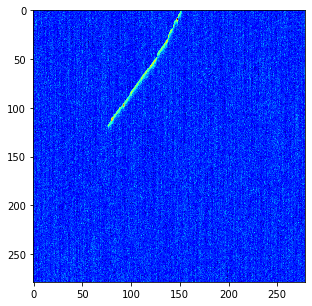

In [34]:
event=40
fig = plt.figure(frameon = False)
plt.imshow(im[:,:,event].T,cmap = 'jet',interpolation='none')
fig.set_size_inches(5, 5) ##grey scale
plt.savefig('small.png')

In [42]:
def dibujar(event,im):
    fig = plt.figure(frameon = False)
    plt.imshow(im[:,:,event].T,cmap = 'jet',interpolation='none')
    fig.set_size_inches(5, 5) ##grey scale
    fig.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


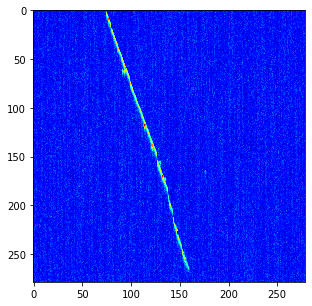

In [44]:
dibujar(6,im)